In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import logging

import dlisio # now this module should be found
from dlisio import dlis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 8.0 MB/s eta 0:00:00


In [30]:
#filename = '/content/drive/MyDrive/Colab Notebooks/NEW-LOGS/University_of_Utah_MU_ESW1_FMI_HD_2226_7550ft_Run1.dlis'

filename = '/content/drive/MyDrive/Colab Notebooks/NEW-LOGS/University_of_Utah_MU_ESW1_FMI_HD_7440_7550ft_Run2.dlis'

# Load the DLIS file, with the first logical file stored in f
# all other logical files stored in f_tail

f, *f_tail = dlis.load(filename)

# Check if there is one or more logical files in f_tail
if len(f_tail): logging.warning('There are more logical files in tail')


In [31]:
# Load the first origin record for the logical file stored in f
# and place all other origin records in origin_tail.

origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

In [32]:
# Print the description of all origin records
for origin in f.origins:
    print(origin.describe())

------
Origin
------
name   : WELL-MU-ESW1
origin : 22
copy   : 0

Logical file ID          : ConPr_R01_L007Up_FBST_DSST
File set name and number : CONPR_R01_L007UP_FBST_DSST / 1
File number and type     : 0 / CUSTOMER

Field                   : None
Well (id/name)          :  / MU-ESW1
Produced by (code/name) : 440 / Schlumberger
Produced for            : University of Utah
Created                 : 2017-10-26 18:51:34

Created by              : Techlog, (version: 2013.4.0 (rev: 128578))
Other programs/services : WELL-MU-ESW1


------
Origin
------
name   : DATASET-FMI_HD_7320-7558ft_shifted
origin : 23
copy   : 0

Logical file ID          : ConPr_R01_L007Up_FBST_DSST
File set name and number : CONPR_R01_L007UP_FBST_DSST / 1
File number and type     : 0 / CUSTOMER

Field                   : None
Well (id/name)          :  / MU-ESW1
Produced by (code/name) : 440 / Schlumberger
Produced for            : University of Utah
Created                 : 2017-10-26 18:51:34

Created by        

In [33]:
# A helper function that extracts specified information from the logical file into a pandas dataframe

def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One
    object pr. row

    Parameters
    ----------

    objs : list()
        list of metadata objects

    **kwargs
        Keyword arguments
        Use kwargs to tell summarize() which fields (attributes) of the
        objects you want to include in the DataFrame. The parameter name
        must match an attribute on the object in 'objs', while the value
        of the parameters is used as a column name. Any kwargs are excepted,
        but if the object does not have the requested attribute, 'KeyError'
        is used as the value.

    Returns
    -------

    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'

            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

In [34]:
# Make a pandas dataframe that contains parameter (constant) details
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

# Add units through the temporary units interface
units_column = []
for i, par in enumerate(f.parameters):
    if i not in parameter_table.index: continue
    try:
        units_column.append(par.attic['VALUES'].units)
    except KeyError:
        units_column.append(None)
parameter_table['Units'] = units_column

# Sort the table alphabetically on parameter name
parameter_table.sort_values('Name')

# Display the first 20 rows of the parameter table
display(parameter_table.head(20))
# note that there are 108 parameters in this example

# Export parameter table to CSV for ease of review
#parameter_table.to_csv('parameter_table.csv', index=False)

,Name,Long name,Value(s),Units
0,SGOR,Solution Gas Oil Ratio,[-999.25],ft3/bbl
1,SGOR,Solution Gas Oil Ratio,[-999.25],ft3/bbl
2,MVIS,Mud Filtrate Viscosity,[1.0],s
3,MVIS,Mud Filtrate Viscosity,[1.0],s
4,MDEC,Magnetic Field Declination,[11.499799728393555],deg
5,MDEC,Magnetic Field Declination,[11.496999740600586],deg
6,MDEC,Magnetic Field Declination,[11.496999740600586],deg
7,SEABDEPTH,Water Depth,[-999.25],ft
8,SEABDEPTH,Water Depth,[-999.25],ft
9,TOWN,Township,[26S],


In [35]:
key_parameters = ['CN', 'WN', 'FN',                                         # Well ID
                   'NATI', 'CONT', 'FL', 'FL1', 'FL2', 'LONG', 'LATI',      # Well location
                   'DLAB', 'TLAB',                                          # Time and date of well logging
                   'CSIZ', 'BS']                                            # Casing and well parameters

# Create a table out of the parameters in desc_parameters
summary_table = parameter_table.loc[parameter_table['Name'].isin(key_parameters)].copy()

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(key_parameters, key_parameters, ordered=True)
summary_table['Name'] = summary_table['Name'].astype(categorical_sorter.dtype)
summary_table.sort_values(by='Name', inplace=True)

display(summary_table)

,Name,Long name,Value(s),Units
679,CN,Company Name,[University of Utah],
678,CN,Company Name,[University of Utah],
601,WN,Well Name,[MU-ESW1],
602,WN,Well Name,[MU-ESW1],
624,FN,Field Name,[None],
623,FN,Field Name,[None],
327,NATI,Nation,[USA],
328,NATI,Nation,[USA],
232,FL,Field Location,"[From the S4 Corner of Sec. 32, T26S, R9W]",
233,FL,Field Location,"[From thr S4 Corner of Sec. 32 T26S, R9W]",


In [36]:
# Load the remarks from the logical file and print them

remarks = f.find('PARAMETER', '^R[0-9]{1,2}')
remarks = sorted(remarks, key=lambda x: int(x.name[1:]) )

for remark in remarks:
    #if not remark.values: continue    # Uncomment to skip empty remarks
    if remark.name == 'R8': continue   # Hide a remark containing a name; comment out the line to show the remark
    print(f'{remark.name}: {" ".join(remark.values)}')

# If there are no remarks (as can be the case with processed data), then nothing will print.

R1: Thank you for choosing Schlumberger!
R2: Tool string run as per tool sketch and client logging program.
R3: TD: 7546 ft. CS: 2175 ft
R9: Toolstring RIH powered off in attempt to prevent tool overheating.
R9: Tool string ran as per tool sketch
R10: 4260' - 4231', were pulling tight. Had to close and open calipers 2 serperate occasions to get free.
R10: Maximum temperature 321 F from EDTC
R11: EMEX disconnected at 2227 ft.
R11: 2 CME-Z used to centralize the tool.
R12: BHT: 253 deg F
R12: Casing Shoe@ 7386ft
R13: TD@7545ft
R13: TD@7545ft


In [37]:
# all channels in one frame are referenced (indexed) against the same value (typically depth)

for frame in f.frames:
    index_channel = next(ch for ch in frame.channels if ch.name == frame.index)
    print(f'Frame {frame.name}:')
    print(f'Description      : {frame.description}')
    print(f'Indexed by       : {frame.index_type}')
    print(f'Interval         : [{frame.index_min}, {frame.index_max}] {index_channel.units}')
    print(f'Direction        : {frame.direction}')
    print(f'Constant spacing : {frame.spacing} {index_channel.units}')
    print(f'Index channel    : {index_channel}')
    print(f'No. of channels  : {len(frame.channels)}')
    print()

Frame 1B:
Description      : 
Indexed by       : BOREHOLE-DEPTH
Interval         : [878344.9613070488, 906940.9378695488] 0.1 in
Direction        : DECREASING
Constant spacing : -1.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 19



In [38]:
channel_table = summarize(
    f.channels,
    name='Name',
    long_name='Long name',
    units='Units',
    dimension='Dimension',
    frame='Frame')

channel_table.sort_values('Name')

display(channel_table)

,Name,Long name,Units,Dimension,Frame
0,TDEP,Tool Depth,0.1 in,[1],Frame(1B)
1,AX,Acceleration X-Axis,m/s2,[1],Frame(1B)
2,AY,Acceleration Y-Axis,m/s2,[1],Frame(1B)
3,AZ,Acceleration Z-Axis,m/s2,[1],Frame(1B)
4,BS,Bit Size,in,[1],Frame(1B)
5,C1_S,Caliper 1,in,[1],Frame(1B)
6,C2_S,Caliper 2,in,[1],Frame(1B)
7,DEVIM_S,Memorized Deviation,deg,[1],Frame(1B)
8,FMI_DYN,Button Resistivity profile corrected for gain ...,,[360],Frame(1B)
9,FMI_STAT,Button Resistivity profile corrected for gain ...,,[360],Frame(1B)


In [39]:
# Make a pandas dataframe that contains tool type information
tool_table = summarize(
    f.tools,
    name='Name',
    generic_name='Generic name',
    trademark_name='Trademark name',
    description='Description')

# Sort the table aphapetically by the tool name
tool_table.sort_values('Name')

,Name,Generic name,Trademark name,Description
0,EDTCB,,EDTC-B,Enhanced Digital Telemetry Cartridge - Version B
1,FBST-E,,FBST-E,Full-Bore Scanner Tool E


In [40]:
# Extract metadata associated with a specific tool
selected_tool = f.object(
    'TOOL',         # object type
    'FBST-E'        # object name from table above
    )

selected_tool.describe()

----
Tool
----
name   : FBST-E
origin : 23
copy   : 0

Description    : Full-Bore Scanner Tool E
Trademark name : FBST-E

Channels   : HAZIM_S     FX          FY          FZ          C1_S
             FMI_STAT    RB_FBST_S   C2_S        DEVIM_S     P1NO_FBST_S AX
             FMI_DYN     AY          AZ          P1AZ
Parameters : AOFFZ               FOCUS_DIP_RT        EMEXREG             CORINT
             FIRMV               AMWL                CORRELAT_CUT
             FOCUS_DIP_AZI       EMXGMOD             AMOR
             MEAS_PNTR           FDBD                AFMO
             C2_SHIFT            MDIP_REJECT         FBST_ACQ_MODE       AMPS
             FDBP                ACAUX_SAFETY        MINC                PADT
             FOFFX               GAIN_FBST           AMIP                FOFFY
             STEP                FOFFZ               APM
             GPITF_LOGGING_SPEED AMRG                MDEC                FIEQ
             EMXCORR             ICMO             

In [41]:
selected_tool_param_table = summarize(
    selected_tool.parameters,
    name='Name',
    long_name='Long name',
    values='Value(s)')

selected_tool_param_table.sort_values('Name')

,Name,Long name,Value(s)
18,ACAUX_SAFETY,AC AUX Current Limit Safety,[On]
12,AFMO,Accelerometer Filtering Mode,[HAMMING]
23,AMIP,Adaptive Mode Initial Phase,[0.0]
61,AMMQ,Adaptive Mode Minimum Quality,[3]
9,AMOR,Adaptive Mode Outliers Rejection,[14]
...,...,...,...
46,RBSI,Auto RBS Change Interval,[10]
63,SEARCH_ANGLE,Angular range to search around focus dip,[60.0]
50,SOFF,Standoff,[-1.0]
25,STEP,Step Length between Correlations,[2.0]


In [42]:
selected_tool_channel_table = summarize(
    selected_tool.channels,
    name='Name',
    long_name='Long name',
    units='Units',
    dimension='Dimension',
    frame='Frame')

selected_tool_channel_table.sort_values('Name')

,Name,Long name,Units,Dimension,Frame
10,AX,Acceleration X-Axis,m/s2,[1],Frame(1B)
12,AY,Acceleration Y-Axis,m/s2,[1],Frame(1B)
13,AZ,Acceleration Z-Axis,m/s2,[1],Frame(1B)
4,C1_S,Caliper 1,in,[1],Frame(1B)
7,C2_S,Caliper 2,in,[1],Frame(1B)
8,DEVIM_S,Memorized Deviation,deg,[1],Frame(1B)
11,FMI_DYN,Button Resistivity profile corrected for gain ...,,[360],Frame(1B)
5,FMI_STAT,Button Resistivity profile corrected for gain ...,,[360],Frame(1B)
1,FX,Magnetometer X-Axis,Oe,[1],Frame(1B)
2,FY,Magnetometer Y-Axis,Oe,[1],Frame(1B)


In [43]:
# Define the frame
# Check available frames in the file
for frame_obj in f.frames:
    print(frame_obj.name)

# Access the frame using its correct name
# Replace 'CORRECT_FRAME_NAME' with the actual name from the printed list
frame = f.object('FRAME', frame_obj.name) # Use frame_obj.name to access the name of the last frame object

frame.describe()

1B


-----
Frame
-----
name   : 1B
origin : 23
copy   : 0

Channel indexing
--
Indexed by       : BOREHOLE-DEPTH
Index units      : 0.1 in
Index min        : 878344.9613070488 [0.1 in]
Index max        : 906940.9378695488 [0.1 in]
Direction        : DECREASING
Constant spacing : -1.0 [0.1 in]
Index channel    : Channel(TDEP)

Channels
--
TDEP        AX          AY          AZ          BS          C1_S        C2_S
DEVIM_S     FMI_DYN     FMI_STAT    FX          FY          FZ
GR_EDTC_S   HAZIM_S     P1AZ        P1NO_FBST_S RB_FBST_S   TENS

In [44]:
# Get all curves from the frame
curves = frame.curves()

# Get the desired curve from the curves
FMI_DYN = curves['FMI_DYN']

# Because we are working with a micro-resistivity image log,
# there are nan values in the gaps between the pads. We need to
# replace the log nan values (-9999.0) with np.nan to make a nice plot.
FMI_DYN[FMI_DYN == -9999.] = np.nan

# Get the index channel (depth) from the frame
DEPT = curves[frame.index]

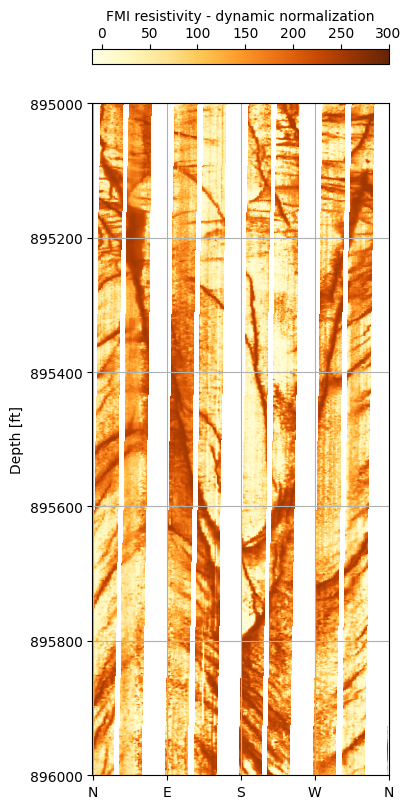

In [51]:
# A helper function for plotting image logs using matplotlib imshow
def paint_channel(ax, curve, y_axis, x_axis, **kwargs):
    """Plot an image channel into an axes using an index channel for the y-axis

    Parameters
    ----------

        ax : matplotlib.axes

        curve : numpy array
            The curve to be plotted

        index : numpy array
            The depth index as a Channel object (slower) or a numpy array (faster)

        **kwargs : dict
            Keyword arguments to be passed on to ax.imshow()
    """
    # Determine the extent of the image so that the pixel centres correspond with the correct axis values
    dx = np.mean(x_axis[1:] - x_axis[:-1])
    dy = np.mean(y_axis[1:] - y_axis[:-1])
    extent = (x_axis[0] - dx/2, x_axis[-1] + dx/2, y_axis[0] - dy/2, y_axis[-1] + dy/2)

    # Determine the correct orientation of the image
    if y_axis[1] < y_axis[0]:   # Frame recorded from the bottom to the top of the well
        origin = 'lower'
    else:                       # Frame recorded from the top to the bottom of the well
        origin = 'upper'

    return ax.imshow(curve, aspect='auto', origin=origin, extent=extent, **kwargs)


# Plot the image log
fig, ax = plt.subplots(1,1, figsize=(4,8), sharey=True, constrained_layout=True)

ang = np.arange(360)

im = paint_channel(ax, FMI_DYN, DEPT, ang, cmap='YlOrBr', vmin=-10, vmax=300)

cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label('FMI resistivity - dynamic normalization')

ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xticklabels(['N', 'E', 'S', 'W', 'N'])

ax.grid(True)

#ax.set_xlabel('Azimuthal angle from north [°]')
ax.set_ylabel('Depth [ft]')

ax.set_ylim(896000, 895000)

plt.show()